<a href="https://colab.research.google.com/github/kundajelab/mfinkels_work/blob/master/av/TrainModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
#download raw data
!wget https://github.com/kundajelab/mfinkels_work/raw/371e0dc637ccf85716d208e312c8f7c0ba3174d4/av/simulation.simdata.gz
!wget https://github.com/kundajelab/mfinkels_work/raw/371e0dc637ccf85716d208e312c8f7c0ba3174d4/av/neg_labels.txt.gz
!wget https://github.com/kundajelab/mfinkels_work/raw/371e0dc637ccf85716d208e312c8f7c0ba3174d4/av/pos_labels.txt.gz

--2020-05-18 08:26:27--  https://github.com/kundajelab/mfinkels_work/raw/371e0dc637ccf85716d208e312c8f7c0ba3174d4/av/simulation.simdata.gz
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kundajelab/mfinkels_work/371e0dc637ccf85716d208e312c8f7c0ba3174d4/av/simulation.simdata.gz [following]
--2020-05-18 08:26:28--  https://raw.githubusercontent.com/kundajelab/mfinkels_work/371e0dc637ccf85716d208e312c8f7c0ba3174d4/av/simulation.simdata.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2093048 (2.0M) [application/octet-stream]
Saving to: ‘simulation.simdata.gz’

simulation.simdata. 100%[================

In [3]:
!gunzip simulation.simdata.gz
!md5sum simulation.simdata

28490a9cd104baf7de558df0e01e7eef  simulation.simdata


In [4]:
!gunzip neg_labels.txt.gz
!head neg_labels.txt

5	3.9556714333663376
0	0.8723493322167508
183	165.86628508719633
83	82.91478903189929
109	102.47376788600042
115	112.80948366668682
0	0.2505610132630518
109	113.12165963419002
208	235.77379484710877
142	120.82657161930747


In [5]:
!gunzip pos_labels.txt.gz
!head pos_labels.txt

0	0.47204300550326533
0	0.0488862697472111
121	128.17060289394672
38	45.300109361586486
60	62.24010378600618
72	71.89019598160023
0	0.0075252597546593145
81	72.18881330157092
210	217.21736987999986
77	79.68836743977995


In [6]:
!pip install simdna

     |████████████████████████████████| 634kB 5.3MB/s 
  ERROR: Failed building wheel for simdna
  Running setup.py clean for simdna
Failed to build simdna
    Running setup.py install for simdna ... done


In [0]:
import simdna
from simdna import synthetic

In [0]:
data = synthetic.read_simdata_file("simulation.simdata")

In [0]:
import numpy as np

#this is set up for 1d convolutions where examples
#have dimensions (len, num_channels) 
#the channel axis is the axis for one-hot encoding.
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

def anscombe_transform(vals):
  return 2*np.sqrt(vals + 3.0/8)

            
onehot_data = np.array([one_hot_encode_along_channel_axis(seq) for seq in data.sequences])

pos_labels = anscombe_transform(np.array([float(x.split("\t")[0]) for
                                          x in open("pos_labels.txt")]))
neg_labels = anscombe_transform(np.array([float(x.split("\t")[0]) for
                                          x in open("neg_labels.txt")]))

pos_oracle = anscombe_transform(np.array([float(x.split("\t")[1]) for
                                          x in open("pos_labels.txt")]))
neg_oracle = anscombe_transform(np.array([float(x.split("\t")[1]) for
                                          x in open("neg_labels.txt")]))

Train model

In [10]:
import keras

def model_arch1():
  model = keras.models.Sequential()
  for i in range(4):
    added_kwarg = {}
    if (i==0):
      added_kwarg["input_shape"] = (100,4)
    model.add(keras.layers.Conv1D(filters=15, kernel_size=7, 
                                  activation = "relu",
                                  kernel_initializer="he_normal",
                                  **added_kwarg))
  model.add(keras.layers.GlobalAveragePooling1D())
  
  for i in range(2):
    model.add(keras.layers.Dense(50, activation="relu",
                                 kernel_initializer="he_normal"))
  model.add(keras.layers.Dense(1, activation="linear"))
  adam = keras.optimizers.Adam()
  model.compile(optimizer=adam, loss="mean_squared_error")
  return model

def train_model(model_constructor, X_train, y_train, X_valid, y_valid, seed):
  np.random.seed(seed)
  model = model_constructor()
  print(model.summary())
  model.fit(x=X_train, y=y_train, batch_size=200,
            epochs=1000,
            validation_data=(X_valid, y_valid),
            callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                                     patience=15,
                                                     restore_best_weights=True)])
  return model

Using TensorFlow backend.


In [12]:
indices_train = np.arange(0, int(0.6 * onehot_data.shape[0]))
indices_val = np.arange(int(0.6 * onehot_data.shape[0]),
                        int(0.8 * onehot_data.shape[0]))
indices_test = np.arange(int(0.8 * onehot_data.shape[0]), onehot_data.shape[0])
X_test = onehot_data[indices_test]
y_test_pos = pos_labels[indices_test]
oracle_test_pos = pos_oracle[indices_test]
y_test_neg = neg_labels[indices_test]
oracle_test_neg = neg_oracle[indices_test]

pos_model1 = train_model(model_constructor=model_arch1,
                         X_train=onehot_data[indices_train],
                         y_train=pos_labels[indices_train],
                         X_valid=onehot_data[indices_val],
                         y_valid=pos_labels[indices_val],
                         seed=1234)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 94, 15)            435       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 88, 15)            1590      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 82, 15)            1590      
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 76, 15)            1590      
_________________________________________________________________
global_average_pooling1d_2 ( (None, 15)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                800       
_________________________________________________________________
dense_5 (Dense)              (None, 50)               

In [31]:
neg_model1 = train_model(model_constructor=model_arch1,
                         X_train=onehot_data[indices_train],
                         y_train=neg_labels[indices_train],
                         X_valid=onehot_data[indices_val],
                         y_valid=neg_labels[indices_val],
                         seed=1234)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 94, 15)            435       
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 88, 15)            1590      
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 82, 15)            1590      
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 76, 15)            1590      
_________________________________________________________________
global_average_pooling1d_3 ( (None, 15)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                800       
_________________________________________________________________
dense_8 (Dense)              (None, 50)               

In [0]:
pos_model1_preds_test = pos_model1.predict(X_test)
neg_model1_preds_test = neg_model1.predict(X_test)

Positive control model:


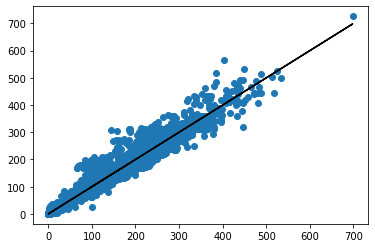

Negative control model:


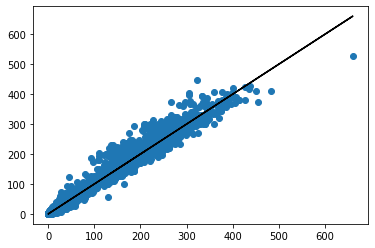

In [37]:
def inverse_anscombe_transform(vals):
  return np.square(vals/2.0) - 3.0/8

def inv_anscombe_plot(x, y):
  inv_x = inverse_anscombe_transform(x)
  inv_y = inverse_anscombe_transform(y)
  plt.plot(inv_x, inv_x, color="black")
  plt.scatter(inv_x, inv_y)
  plt.show()

%matplotlib inline
from matplotlib import pyplot as plt
print("Positive control model:")
inv_anscombe_plot(pos_model1_preds_test, oracle_test_pos)

print("Negative control model:")
inv_anscombe_plot(neg_model1_preds_test, oracle_test_neg)

In [25]:
import string
import random

barcode = ''.join(random.choice(string.ascii_lowercase) for i in range(5))
print(barcode)
pos_model1.save("pos_model1_"+barcode+".h5")

cesjm


In [34]:
barcode = ''.join(random.choice(string.ascii_lowercase) for i in range(5))
print(barcode)
neg_model1.save("neg_model1_"+barcode+".h5")

dlfym


In [35]:
!du -hs *

1.1M	neg_labels.txt
152K	neg_model1_dlfym.h5
1.1M	pos_labels.txt
152K	pos_model1_cesjm.h5
55M	sample_data
7.4M	simulation.simdata
